In [1]:
#For numerics
import numpy as np

#For reading data
import pandas as pd

#For plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

#For TeX plots
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

#For colorblind plots
import seaborn
colors = list(seaborn.color_palette('colorblind').as_hex())

#For setting root path
import sys
import os

root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if root not in sys.path:
    sys.path.append(root)
    
if os.getcwd() != root:
    os.chdir(root)

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

from lfv_higgs_decays.formulae.higgs_decay_signals import (ta_to_Cij,
                                                           Cij_to_ta,
                                                           BR_aa_OSSF0,
                                                           H_to_OSSF0_signal_efficiency,
                                                           #BR_H_X_to_Cah
                                                           )

from lfv_higgs_decays.fits.displaced_fits import ATLAS_fit, MATH_fit

from lfv_higgs_decays.limits import Cah_limit_CMS, Cah_limit_ATLAS, Cah_limit_MATH, Cll_limit

from phys.formulae.ALP_EFT import ALP_fermion_decay_rate, ALP_photon_decay_rate, ALP_decay_rate, Higgs_ALP_decay_rate
from phys.constants import ml, H_width_SM

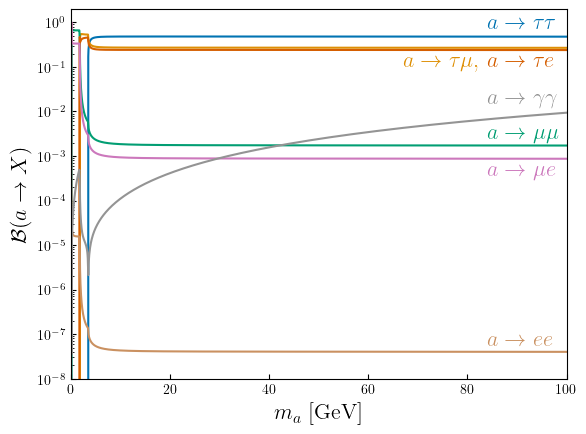

In [2]:
# Assuming democratic couplings
Cll = [[1]*3]*3
Cgg = 0

plot_masses = np.logspace(-4, 2, 1000)

idx = 0
#First, plot the branching fractions for ALP -> li lj
for i, j in reversed([(0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]):
    BR = ALP_fermion_decay_rate(plot_masses, ml[i], ml[j], Cij = Cll[i][j])
    if i != j:
        BR *= 2 #accounts for li^+ lj^- and lj^+ li^-
    BR/= ALP_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
    plt.plot(plot_masses, BR, color = colors[idx])
    idx = idx+1

#Now, branching into photons (assuming tree-level Cgg = 0)
BR = ALP_photon_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
BR/= ALP_decay_rate(plot_masses, Cff = Cll, Cgg = Cgg)
plt.plot(plot_masses, BR, color = colors[idx+1])

#Label each curve
plt.text(84, 0.7, '$a\\rightarrow\\tau\\tau$', fontsize = 16, color = colors[0])
plt.text(67, 0.1, '$a\\rightarrow\\tau\\mu,$', fontsize = 16, color = colors[1])
plt.text(84, 0.1, '$a\\rightarrow \\tau e$', fontsize = 16, color = colors[3])
plt.text(84, 1.5e-2, '$a\\rightarrow\\gamma\\gamma$', fontsize = 16, color = colors[7])
plt.text(84, 2.5e-3, '$a\\rightarrow\\mu\\mu$', fontsize = 16, color = colors[2])
plt.text(84, 3.6e-4, '$a\\rightarrow\\mu e$', fontsize = 16, color = colors[4])
plt.text(84, 5.5e-8, '$a\\rightarrow e e$', fontsize = 16, color = colors[5])


plt.tick_params(which = 'both', direction = 'in')
plt.xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
plt.ylabel('${\\cal B}(a\\rightarrow X)$', fontsize = 16)
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(1e-8,2e0)

plt.savefig('figures/chapter5/LFV_ALP_branching_fraction.pdf', format = 'pdf')

## Prompt

Let us load in the data generated from MadGraph for $H \rightarrow a a \rightarrow \mu^+\mu^+e^-e^-$. 

In [3]:
mass_MG, crossx_MG, N_events_MG, N_error_MG, eff_MG = np.loadtxt('lfv_higgs_decays/data/H_to_OSSF0_MG.txt', skiprows = 1).T

Before plotting the efficiency, we can do a sanity check by comparing the theory cross-section to the cross-section generated by MadGraph. We normalize the cross-section by $55~{\rm fb}$ which is the cross-section for gluon-gluon fusion at $14 {\rm TeV}$ at CERN. We see that the functional form is correct, although we find a $10\%$ disagreement, but this may just be due to an incorrect normalization.

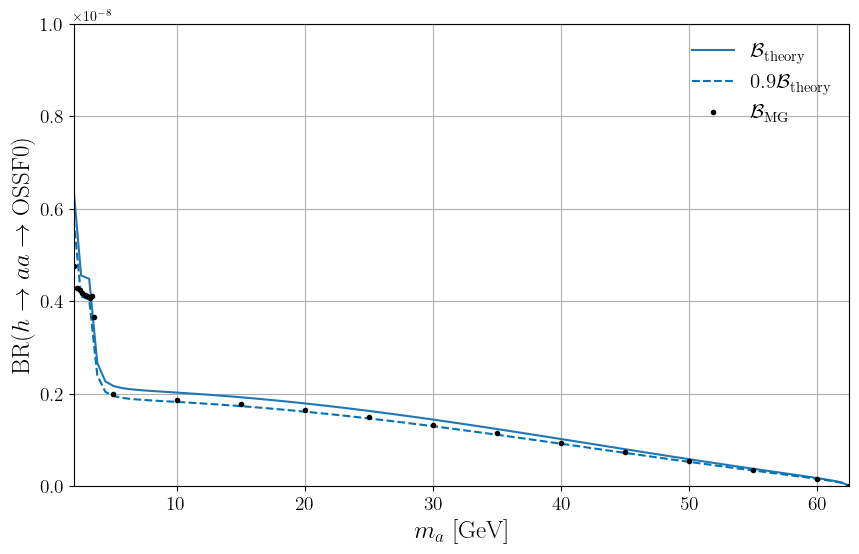

In [4]:
BR_lept_prompt_fig, ax = plt.subplots(figsize = (10, 6))

plot_masses = np.linspace(0, 62.5, 100)

Cll = []
H_aa_width = Higgs_ALP_decay_rate(plot_masses, 1e-3, Cahp = 0, Lam = 1000)
BR_H_OSSF0 = BR_aa_OSSF0(plot_masses) * H_aa_width/(H_width_SM + H_aa_width)

ax.plot(plot_masses, BR_H_OSSF0, label = '$\\mathcal{B}_{\\rm theory}$')
ax.plot(plot_masses, 0.9*BR_H_OSSF0, label = '$0.9\\mathcal{B}_{\\rm theory}$', color = colors[0], linestyle = '--')
ax.plot(mass_MG, crossx_MG/(55), '.', color = 'black', label = "$\\mathcal{B}_{\\rm MG}$")

ax.set_xlim(2.0,62.5)
ax.set_ylim(0,1e-8)
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 18)
ax.set_ylabel('$\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{OSSF0})$', fontsize = 18)

ax.legend()

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.grid()

ax.legend(prop={"size":15}, frameon = False, loc = 'upper right')

Now we can plot the number of detected signal events and the corresponding efficiency.

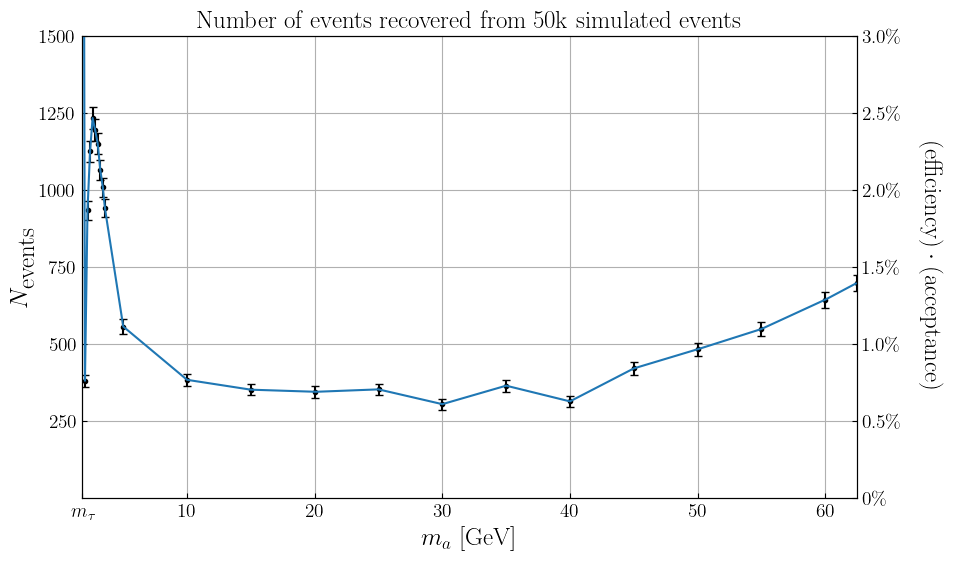

In [5]:
plot_masses = np.arange(1.7, 62.5, 0.1)

N_fig, N_ax = plt.subplots(figsize = (10, 6))

eff_ax = N_ax.twinx()

eff = H_to_OSSF0_signal_efficiency(plot_masses)

eff_ax.plot(plot_masses, eff)
N_ax.errorbar(mass_MG, N_events_MG, yerr = N_error_MG, fmt = '.', capsize = 3, color = 'black')


N_ax.set_xticks([1.777] + [i for i in range(10, 62, 10)], ['$m_{\\tau}$'] + [f'${i}$' for i in range(10, 62, 10)])
N_ax.set_ylim(0, 0.03*50000)
N_ax.set_yticks([250, 500, 750, 1000, 1250, 1500])

N_ax.tick_params(which = 'both', direction = 'in')
N_ax.tick_params(axis='x', labelsize=14)
N_ax.tick_params(axis='y', labelsize=14)
N_ax.ticklabel_format(axis="y")

N_ax.grid()

eff_ax.set_xlim(1.777, 62.5)
eff_ax.set_ylim(0,0.03)
eff_ticks = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
eff_labels = [f'${100*tick}\\%$' for tick in eff_ticks]
eff_ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], eff_labels)

eff_ax.tick_params(which = 'both', direction = 'in')
eff_ax.tick_params(axis='x', labelsize=14)
eff_ax.tick_params(axis='y', labelsize=14)
eff_ax.ticklabel_format(axis="y")

N_ax.set_title('$\\textrm{Number of events recovered from 50k simulated events}$',
             fontsize = 18)
eff_ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 18)
eff_ax.set_ylabel('$\\textrm{(efficiency)}\\cdot\\textrm{(acceptance)}$', fontsize = 18,rotation=270, labelpad = 30)

N_ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 18)
N_ax.set_ylabel('$N_{\\textrm{events}}$', fontsize = 18)

plt.savefig('figures/chapter5/H_to_OSSF0_efficiency.pdf', format = 'pdf')

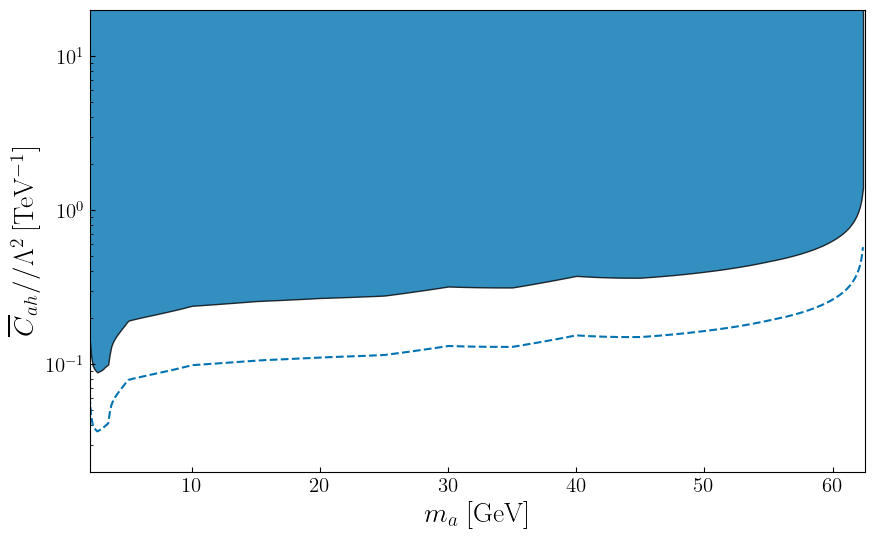

In [6]:
fig,ax = plt.subplots(figsize = (10, 6))

Cll = [[1]*3]*3
plot_masses = np.linspace(2, 62.5, 500)

L = 137
Cah_limits = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
plt.fill_between(plot_masses, Cah_limits, 20, color = colors[0], edgecolor = 'black', alpha = 0.8)

L = 3000
Cah_projections = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
plt.plot(plot_masses, Cah_projections, color = colors[0], linestyle = 'dashed')

ax.set_ylim(2e-2, 20)
ax.set_xlim(2.0,62.5)
ax.set_yscale('log')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 20)
ax.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], prop={"size":15}, frameon = False, loc = 'lower right')

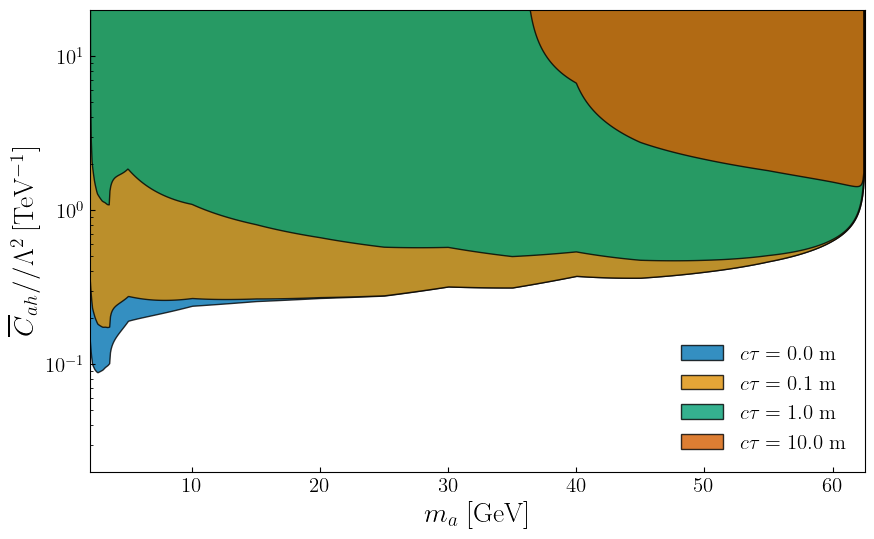

In [7]:
fig,ax = plt.subplots(figsize = (10, 6))

plot_masses = np.linspace(1.77, 62.5, 1000)
plot_ta = np.array([0, 0.1, 1, 10])

Cll = [[1]*3]*3
L = 137

Cah_limit =  Cah_limit_CMS(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1),  Cll = Cll, L = L).T

for idx, (ta, limit) in enumerate(zip(plot_ta, Cah_limit)):
    plt.fill_between(plot_masses, limit, 20,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8, label = f'$c\\tau = {ta}~{{\\rm m}}$')

ax.set_ylim(2e-2, 20)
ax.set_xlim(2.0,62.5)
ax.set_yscale('log')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 20)
ax.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={"size":15}, frameon = False, loc = 'lower right')


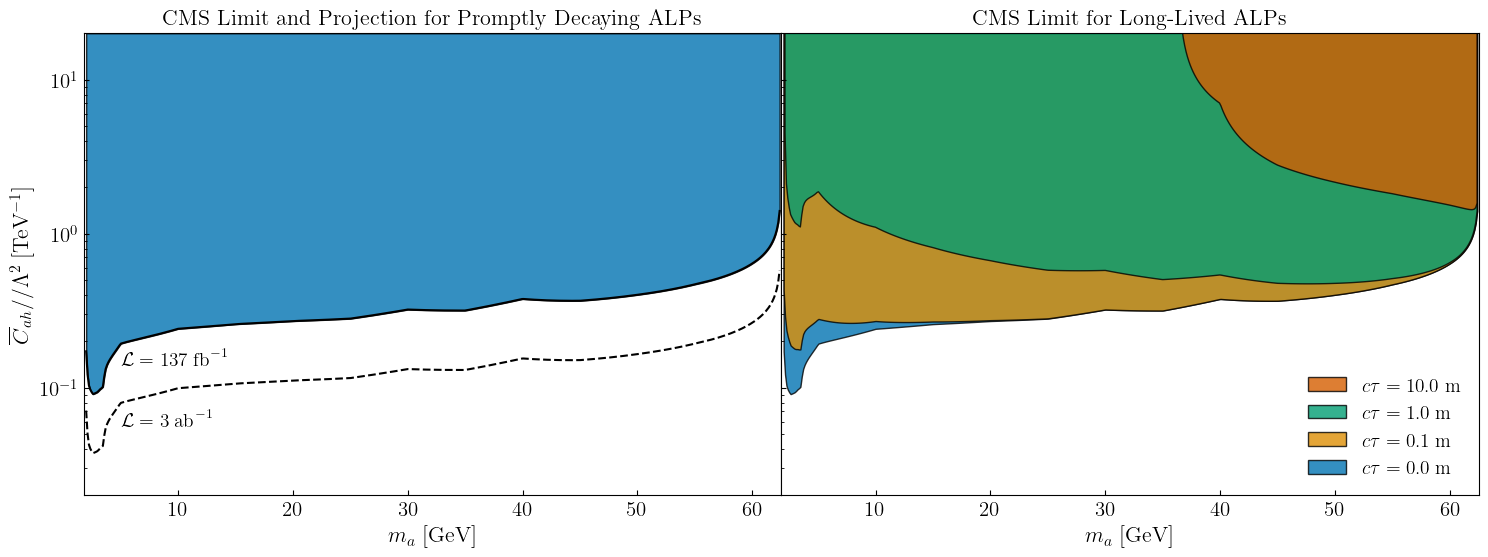

In [8]:
fig = plt.figure(figsize = (18, 6))
gs = GridSpec(1, 2, wspace = 0)

Cll = [[1, 0, 1], 
       [0, 1, 1], 
       [1, 1, 1]]
plot_masses = np.linspace(2, 62.5, 500)


ax1 = fig.add_subplot(gs[0])

L = 137
Cah_limits = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
ax1.fill_between(plot_masses, Cah_limits, 20, color = colors[0], edgecolor = 'black', alpha = 0.8)
ax1.plot(plot_masses, Cah_limits, color = 'black')

L = 3000
Cah_projections = Cah_limit_CMS(plot_masses, 0, Cll = Cll, L = L)
ax1.plot(plot_masses, Cah_projections, color = 'black', linestyle = 'dashed')

ax1.set_title('$\\textrm{ CMS Limit and Projection for Promptly Decaying ALPs}$', fontsize = 16)
ax1.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 16)

ax1.text(5, 1.4e-1, '${\\cal L} = 137~{\\rm fb}^{-1}$', fontsize = 14)
ax1.text(5, 5.6e-2, '${\\cal L} = 3~{\\rm ab}^{-1}$', fontsize = 14)

ax2 = fig.add_subplot(gs[1])

L = 137
Cah_limit =  Cah_limit_CMS(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1),  Cll = Cll, L = L).T

for idx, (ta, limit) in enumerate(zip(plot_ta, Cah_limit)):
    ax2.fill_between(plot_masses, limit, 20,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8, label = f'$c\\tau = {ta}~{{\\rm m}}$')
ax2.set_title('$\\textrm{CMS Limit for Long-Lived ALPs}$', fontsize = 16)

axes = [ax1, ax2]
for ax in axes:
    ax.set_ylim(2e-2, 20)
    ax.set_xlim(1.77,62.5)
    ax.set_yscale('log')
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.tick_params(which = 'both', direction = 'in')
    if ax == ax2:
        ax.tick_params(labelleft = False)
        
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 16)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], prop={"size":14}, frameon = False, loc = 'lower right')

plt.savefig('figures/chapter5/Cah_CMS_constraint.pdf')

This won't make it into the thesis, but we can see how the "democratic" limits compare to the opposite extreme of a single off-diagonal coupling $C_{\tau \ell}$ (which $\ell$ it is hardly makes a difference).

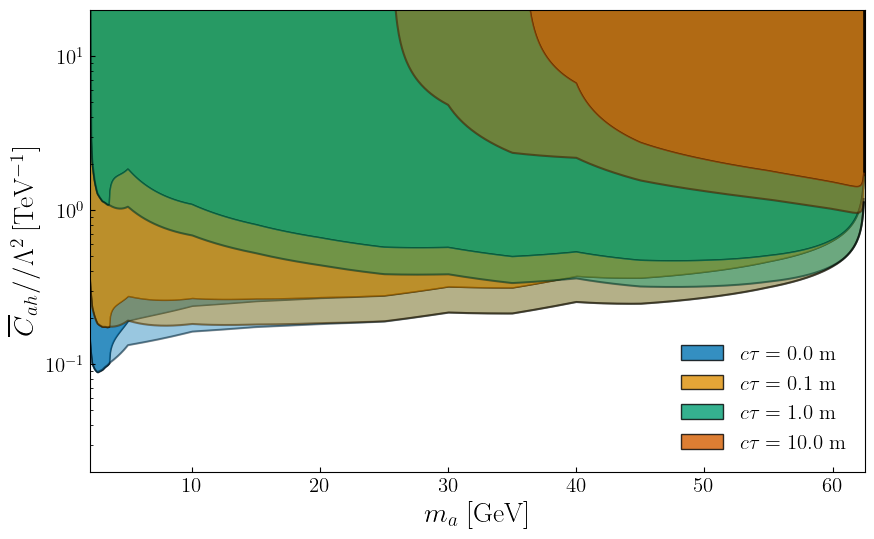

In [9]:
fig,ax = plt.subplots(figsize = (10, 6))

plot_masses = np.linspace(1.77, 62.5, 1000)
plot_ta = np.array([0, 0.1, 1, 10])

L = 137
for idx, ta in enumerate(plot_ta):
    Cll = [[1]*3]*3
    limit =  Cah_limit_CMS(plot_masses, ta,  Cll = Cll, L = L)
    plt.fill_between(plot_masses, limit, 20,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8, label = f'$c\\tau = {ta}~{{\\rm m}}$')

    Cll = [[0, 0, 0],
           [0, 0, 1],
           [0, 1, 0]]
    off_diagional_limit =  Cah_limit_CMS(plot_masses, ta,  Cll = Cll, L = L)
    plt.fill_between(plot_masses, off_diagional_limit, limit,
                     color = colors[idx],
                     alpha = 0.4)
    plt.plot(plot_masses, off_diagional_limit,
             color = 'black',
             alpha = 0.4)

ax.set_ylim(2e-2, 20)
ax.set_xlim(2.0,62.5)
ax.set_yscale('log')

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$m_a\\textrm{ [GeV]}$', fontsize = 20)
ax.set_ylabel('$\\overline{C}_{ah}//\Lambda^2~[\\rm TeV^{-1}]$', fontsize = 20)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={"size":15}, frameon = False, loc = 'lower right')

There are two reasons for this: the lifetime is smaller, and the branching fraction into OSOF pairs is larger.

## ATLAS

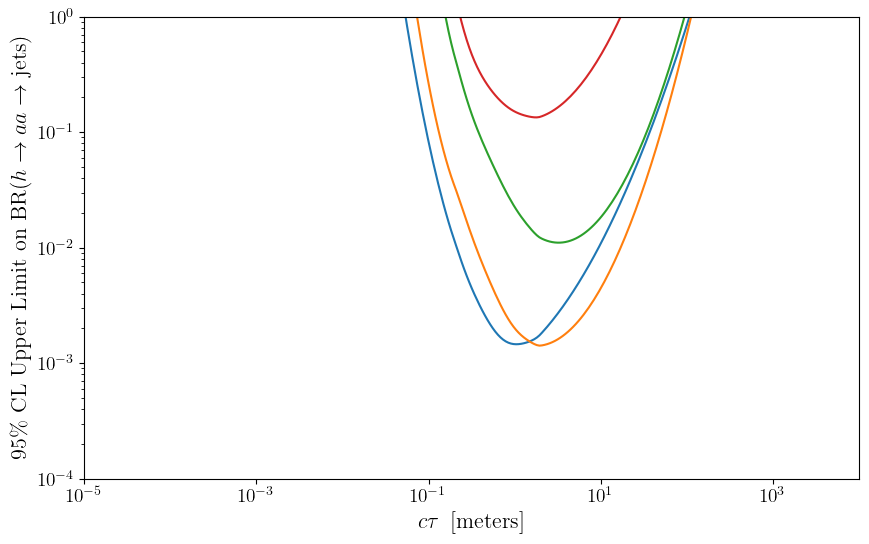

In [10]:
fig, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([15, 25, 40, 55])
plot_ta = np.logspace(-3,3,200)

BR_constraint = ATLAS_fit(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1))

for mass, constraint in zip(plot_masses, BR_constraint):
    plt.plot(plot_ta, constraint)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,1e0)
ax.set_xlim(1e-5,1e4)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('$c\\tau\\,\\textrm{ [meters]}$', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

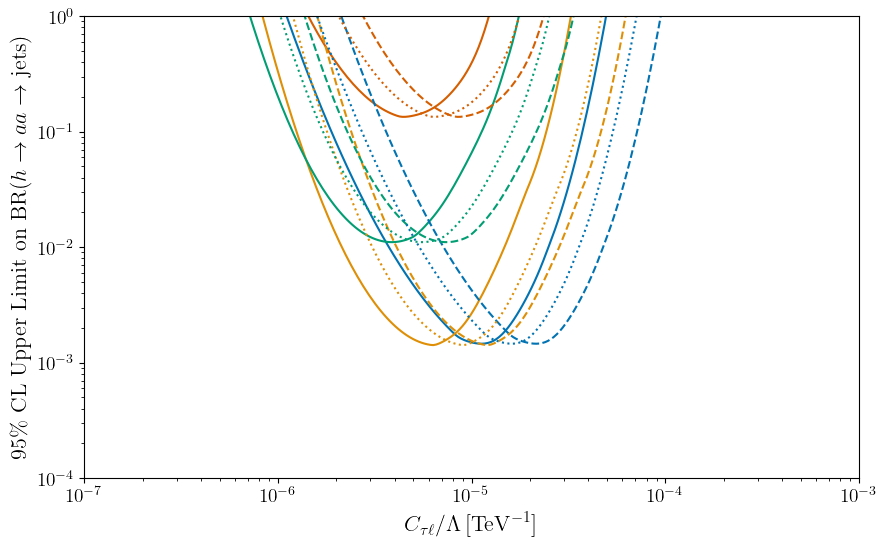

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([15, 25, 40, 55])
plot_ta = np.logspace(-3,3,200)

BR_constraint = ATLAS_fit(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1))

Cll = [[0, 0, 1],
       [0, 0, 1],
       [1, 1, 1]]
plot_Cll = ta_to_Cij(plot_ta.reshape(1, -1), plot_masses.reshape(-1, 1), idx = (2, 2), Cll = Cll)

for idx, (mass, constraint) in enumerate(zip(plot_masses, BR_constraint)):
    plt.plot(plot_Cll[idx], constraint, color = colors[idx])
    
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
plot_Cll = ta_to_Cij(plot_ta.reshape(1, -1), plot_masses.reshape(-1, 1), idx = (1, 2), Cll = Cll)

for idx, (mass, constraint) in enumerate(zip(plot_masses, BR_constraint)):
    plt.plot(plot_Cll[idx], constraint, color = colors[idx], linestyle = 'dashed')

    
Cll = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]]
plot_Cll = ta_to_Cij(plot_ta.reshape(1, -1), plot_masses.reshape(-1, 1), idx = (2, 2), Cll = Cll)

for idx, (mass, constraint) in enumerate(zip(plot_masses, BR_constraint)):
    plt.plot(plot_Cll[idx], constraint, color = colors[idx], linestyle = 'dotted')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,1e0)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda\\,[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

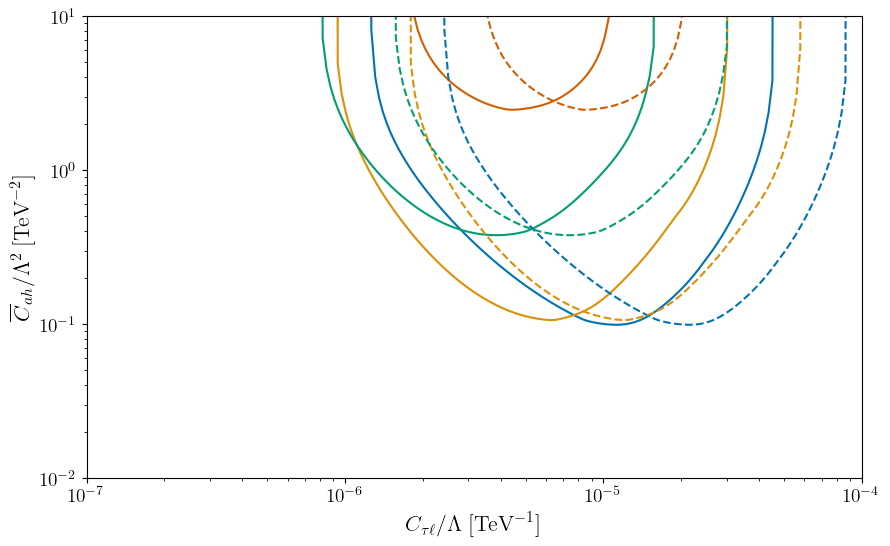

In [12]:
fig, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([15, 25, 40, 55])
plot_ta = np.logspace(-3,3,200)


Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
plot_Cll = ta_to_Cij(plot_ta.reshape(1, -1), plot_masses.reshape(-1, 1), idx = (1, 2), Cll = Cll)
Cah_constraint = Cah_limit_ATLAS(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1), Cah = (1, 0))

for idx, (mass, constraint) in enumerate(zip(plot_masses, Cah_constraint)):
    plt.plot(plot_Cll[idx], constraint, color = colors[idx])
    
Cll = [[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0]]
plot_Cll = ta_to_Cij(plot_ta.reshape(1, -1), plot_masses.reshape(-1, 1), idx = (1, 2), Cll = Cll)
Cah_constraint = Cah_limit_ATLAS(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1), Cah = (1, 0))

for idx, (mass, constraint) in enumerate(zip(plot_masses, Cah_constraint)):
    plt.plot(plot_Cll[idx], constraint, color = colors[idx], linestyle = 'dashed')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,10)
ax.set_xlim(1e-7,1e-4)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

## MATHUSLA

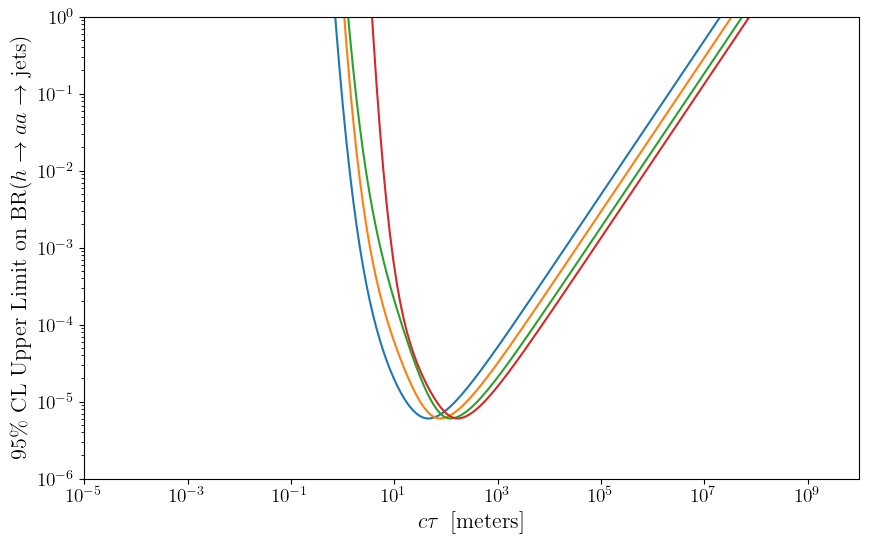

In [13]:
fig, ax = plt.subplots(figsize = (10,6))

plot_masses = np.array([15, 25, 40, 55])
plot_ta = np.logspace(-3,10,200)

BR_constraint = MATH_fit(plot_masses.reshape(-1, 1), plot_ta.reshape(1, -1))

for mass, constraint in zip(plot_masses, BR_constraint):
    plt.plot(plot_ta, constraint)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-6,1e0)
ax.set_xlim(1e-5,1e10)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('$c\\tau\\,\\textrm{ [meters]}$', fontsize = 16)
ax.set_ylabel('$95\\%\\textrm{ CL Upper Limit on }\\textrm{BR}(h\\rightarrow aa \\rightarrow \\textrm{jets})$', fontsize = 16)
ax.legend(prop={"size":16}, frameon = False, loc = "upper left")

## Combined LFV Coupling Constraints

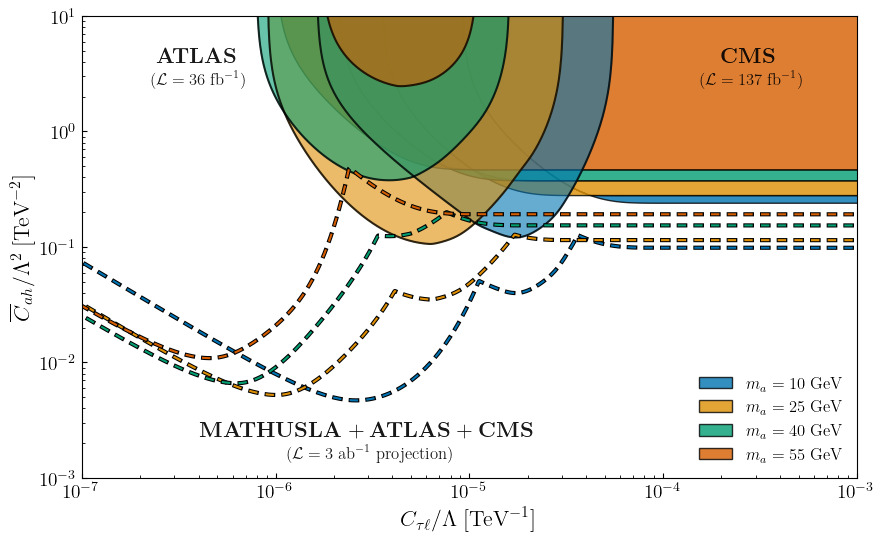

In [14]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]
idx = (1, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')
    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

#######################
#       MATHUSLA      #
#######################

#Projection
Cah_MATH_proj = Cah_limit_MATH(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

Cah_proj = np.min(np.array([Cah_CMS_proj, Cah_ATLAS_proj, Cah_MATH_proj]), axis = 0)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = 'black', linewidth=3, dashes= (2.24, 1.44, 0.32, 0))
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = colors[idx], linewidth=1.5, dashes=(4, 4))

ax.text(2.4e-7, 4, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(2.27e-7, 2.6, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)
ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(4e-7, 2.3e-3, '$\\rm \\bf MATHUSLA+ATLAS+CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.15e-6, 1.5e-3, '$({\\cal L} = 3~{\\rm ab}^{-1}~{\\rm projection})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

plt.savefig('figures/chapter5/Cah_vs_Ctl_limits.pdf', format = 'pdf')

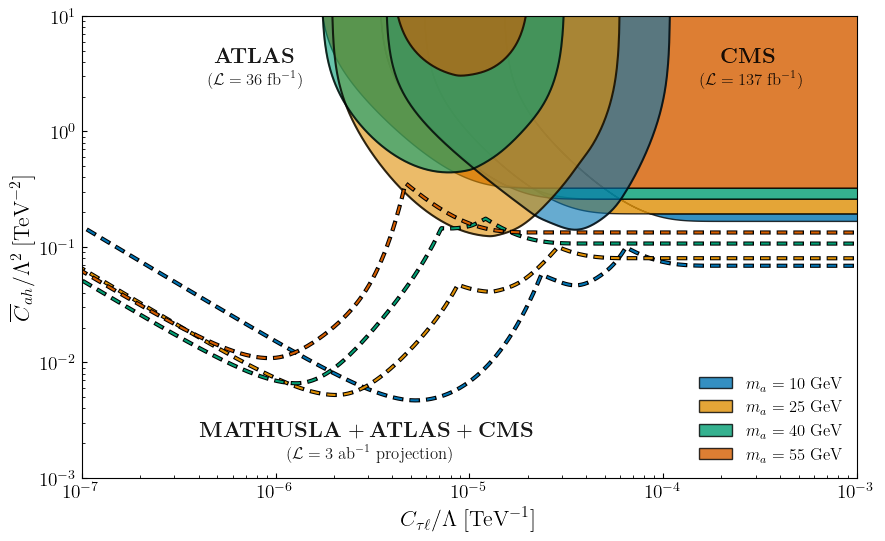

In [15]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]
idx = (0, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')
    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

#######################
#       MATHUSLA      #
#######################

#Projection
Cah_MATH_proj = Cah_limit_MATH(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

#for idx, (mass, constraint) in enumerate(zip(plot_masses, Cah_constraint)):
#    plt.plot(plot_Cll[idx], constraint, color = colors[idx], linestyle = 'dashed')
 
Cah_proj = np.min(np.array([Cah_CMS_proj, Cah_ATLAS_proj, Cah_MATH_proj]), axis = 0)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = 'black', linewidth=3, dashes= (4/5 * 5.6/2, 4/5 * 3.6/2, 4/5 * 0.8/2, 0/2))
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = colors[idx], linewidth=1.5, dashes=(4, 4))

ax.text(4.8e-7, 4, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(4.5e-7, 2.6, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)
ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(4e-7, 2.3e-3, '$\\rm \\bf MATHUSLA+ATLAS+CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.15e-6, 1.5e-3, '$({\\cal L} = 3~{\\rm ab}^{-1}~{\\rm projection})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

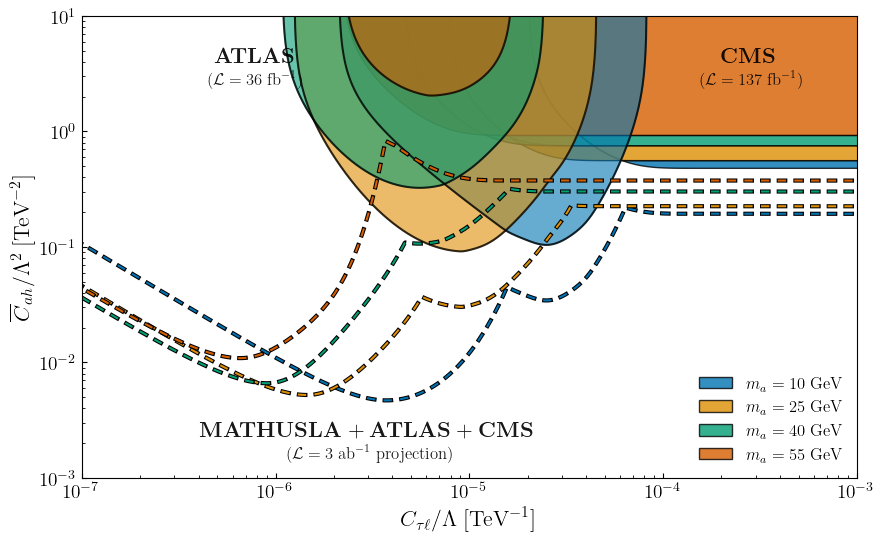

In [16]:
fig, ax = plt.subplots(figsize = (10,6))

Cll = [[0, 0, 0],
       [0, 0, 0],
       [0, 0, 1]]
idx = (2, 2)

plot_masses = np.array([10, 25, 40, 55]).reshape(-1, 1)
plot_ta = np.logspace(-6,6,2000).reshape(1, -1)
plot_Cll = ta_to_Cij(plot_ta, plot_masses, idx = idx, Cll = Cll)

#######################
#         CMS         #
#######################

#Limit
Cah_CMS = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 137)

#Projection
Cah_CMS_proj = Cah_limit_CMS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, ma in enumerate(plot_masses.squeeze()):
    upper = 20 if idx == 3 else np.maximum(Cah_CMS[idx+1], Cah_CMS[idx])    
    plt.fill_between(plot_Cll[idx], Cah_CMS[idx], upper,
                     color = colors[idx],
                     edgecolor = 'black',
                     alpha = 0.8,
                     label = f'$m_a = {ma}~{{\\rm GeV}}$')
    
#######################
#        ATLAS        #
#######################

#Limit
Cah_ATLAS = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

#Projection
Cah_ATLAS_proj = Cah_limit_ATLAS(plot_masses, plot_ta, which = 'Cah', Cll = Cll, L = 3000)

for idx, mass in enumerate(plot_masses.squeeze()):
    plt.fill_between(plot_Cll[idx], Cah_ATLAS[idx], 20,
                     color = colors[idx],
                     alpha = 0.6)
    plt.plot(plot_Cll[idx], Cah_ATLAS[idx], color = 'black', alpha = 0.8)

#######################
#       MATHUSLA      #
#######################

#Projection
Cah_MATH_proj = Cah_limit_MATH(plot_masses, plot_ta, which = 'Cah', Cll = Cll)

Cah_proj = np.min(np.array([Cah_CMS_proj, Cah_ATLAS_proj, Cah_MATH_proj]), axis = 0)
for idx, mass in enumerate(plot_masses.squeeze()):
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = 'black', linewidth=3, dashes= (4/5 * 5.6/2, 4/5 * 3.6/2, 4/5 * 0.8/2, 0/2))
    plt.plot(plot_Cll[idx], Cah_proj[idx], color = colors[idx], linewidth=1.5, dashes=(4, 4))

ax.text(4.8e-7, 4, '$\\rm \\bf ATLAS$', fontsize = 16, alpha = 0.9)
ax.text(4.5e-7, 2.6, '$({\\cal L} = 36~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)
ax.text(2e-4, 4, '$\\rm \\bf CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.55e-4, 2.6, '$({\\cal L} = 137~{\\rm fb}^{-1})$', fontsize = 12, alpha = 0.9)

ax.text(4e-7, 2.3e-3, '$\\rm \\bf MATHUSLA+ATLAS+CMS$', fontsize = 16, alpha = 0.9)
ax.text(1.15e-6, 1.5e-3, '$({\\cal L} = 3~{\\rm ab}^{-1}~{\\rm projection})$', fontsize = 12, alpha = 0.9)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,10)
ax.set_xlim(1e-7,1e-3)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(which = 'both', direction = 'in')
ax.set_xlabel('$C_{\\tau\\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 16)
ax.set_ylabel('$\\overline{C}_{ah}/\\Lambda^2~[{\\rm TeV}^{-2}]$', fontsize = 16)
ax.legend(fontsize = 12, frameon = False, loc = "lower right")

In [17]:
def plot_Higgs_decay_limits(ma, Cah, ax = None, which = 'Cah', ij = (0, 2), Cll = [[1]*3]*3,  CMS_color = colors[0], ATLAS_color = colors[1]):

    if not ax:
        ax = plt.gca()
    
    ############# Constraints ##############

    #######################
    #         CMS         #
    #######################
    
    Cll_limits_CMS = Cll_limit(ma, Cah,
                               which = which,
                               ij = ij,
                               Cll_range = (1e-10, 1e2),
                               npts = 400,
                               detector = 'CMS',
                               Cll = Cll
                               )
    
    #######################
    #        ATLAS        #
    #######################

    Cll_limits_ATLAS = Cll_limit(ma, Cah,
                                 ij = ij,
                                 which = which,
                                 Cll_range = (1e-10, 1e2),
                                 npts = 400,
                                 detector = 'ATLAS',
                                 Cll = Cll
                                 )

    ############# Projections ##############

    Cll_projections = Cll_limit(ma, Cah,
                                which = which,
                                ij = ij,
                                Cll_range = (1e-10, 1e2),
                                npts = 400,
                                detector = ['CMS', 'ATLAS', 'MATHUSLA'],
                                projection = True,
                                Cll = Cll
                              )

    #First, plot lifetime contours
    for exp in range(-12, 7, 3):
        ta = 10.0**exp
        Cij_from_ta = ta_to_Cij(ta, ma, Cll = Cll, idx = ij)
        ax.plot(ma, Cij_from_ta, color = 'black', linewidth = 0.25)
        
        plt.text(53.5, 1.35*ta_to_Cij(ta, 62.5, Cll = Cll, idx = ij), f'$c\\tau_a = 10^{{{exp}}}~{{\\rm m}}$', fontsize = 10)

    #Projections
    for limit in Cll_projections:
        ax.plot(*limit, color = 'black', dashes = (8, 8), linewidth = 0.5)
        ax.fill(*limit, color = 'grey' , alpha = 0.075)

    #CMS
    for limit in Cll_limits_CMS:
        ax.fill(*limit, color = CMS_color, edgecolor = 'black', alpha = 0.6)

    #ATLAS
    for limit in Cll_limits_ATLAS:
        ax.fill(*limit, color = ATLAS_color, edgecolor = 'black', alpha = 0.6)

    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)
    ax.set_xlim(1.77, 62.5)
    ax.set_xlabel('$m_a~[{\\rm GeV}]$', fontsize = 14)
    ax.set_ylim(1e-9, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel('$C_{\\tau \\ell}/\\Lambda~[{\\rm TeV}^{-1}]$', fontsize = 14)
    return ax
    
from scipy.special import erfinv
from lfv_lepton_observables.limits import (radiative_processes,
                                           radiative_decay_limit,
                                           trilepton_processes,
                                           trilepton_decay_limit,
                                           magnetic_dipole_moment_limit
                                           )

def lepton_decay_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):

    # By default, limit is 90% confidence. Limit is proportional to
    # (90% upper bound on decay rate)^{1/4}. For a Poisson counting
    # experiment with zero observed events, the upper bound on the
    # mean is proportional to -log(1 - confidence). 
    # In practice, this will barely change anything. For example.
    # (log(1 - 0.95)/log(1 - 0.9))^(1/4) = 1.068
    
    z_score_conf = -np.log(1-confidence)
    z_score_90 = -np.log(0.1)
    factor = (z_score_conf/z_score_90)**(1/4)
    
    limit = {}
    if which == 'radiative':
        for process in radiative_processes:
            limit[process] = factor*radiative_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    elif which == 'trilepton':
        for process in trilepton_processes:
            limit[process] = factor*trilepton_decay_limit(ma, process, ij+ij, g = Cll, mode = mode, ALP = True)
    return limit

def lepton_dipole_limits(ma, ij, Cll = np.ones((3, 3)), mode = 'PC', confidence = 0.95, which = 'radiative'):

    limit = {}
    for i in range(3):
        limit[i] = magnetic_dipole_moment_limit(ma, i, ij, g = Cll, mode = mode, ALP = True)
        
    return limit
    
def plot_lepton_observable_limits(ma, ij, ax = None, Cll = np.ones((3,3)),
                                  color = colors[8], plot_lines = False,
                                  radiative_color = colors[3],
                                  trilepton_color = colors[4],
                                  dipole_color = colors[5]):
    
    if not ax:
        ax = plt.gca()
        
    PC_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'radiative').values())
    PC_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'PC', which = 'trilepton').values())
    PC_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'PC').values())
    PC_limits = PC_radiative_limits+PC_trilepton_limits+PC_dipole_limits
    
    chiral_radiative_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'radiative').values())
    chiral_trilepton_limits = list(lepton_decay_limits(ma, ij, Cll = Cll, mode = 'chiral', which = 'trilepton').values())
    chiral_dipole_limits = list(lepton_dipole_limits(ma, ij, Cll = Cll, mode = 'chiral').values())
    chiral_limits = chiral_radiative_limits+chiral_trilepton_limits+chiral_dipole_limits
    
    absolute_chi_limit = np.nanmin(chiral_limits, axis = 0)
    absolute_PC_limit = np.nanmin(PC_limits, axis = 0)
    absolute_limit = np.nanmin(PC_limits+chiral_limits, axis = 0)
    
    ax.fill_between(ma, absolute_limit, 1e3, color = color, alpha = 0.1)
    ax.plot(ma, absolute_chi_limit, 1e3, color = 'black', linewidth = 0.5, dashes = (4, 8))
    ax.plot(ma, absolute_PC_limit, 1e3, color = 'black', linewidth = 0.5)
    ax.plot(ma, absolute_limit, 1e3, color = 'black', linewidth = 0.5)
    
    if plot_lines:
        for chi, PC in zip(chiral_radiative_limits, PC_radiative_limits):
            ax.plot(ma, PC, color = radiative_color, linewidth = 0.5)
            ax.plot(ma, chi, color = radiative_color, linestyle = 'dashed', linewidth = 0.5)
        for chi, PC in zip(chiral_trilepton_limits, PC_trilepton_limits):
            ax.plot(ma, PC, color = trilepton_color, linewidth = 0.5)
            ax.plot(ma, chi, color = trilepton_color, linestyle = 'dashed', linewidth = 0.5)
        for chi, PC in zip(chiral_dipole_limits, PC_dipole_limits):
            ax.plot(ma, PC, color = dipole_color, linewidth = 0.5)
            ax.plot(ma, chi, color = dipole_color, linestyle = 'dashed', linewidth = 0.5)

    return ax

In [18]:
def plot_combined_limits(ma, Cah_vals, figsize = None, which = 'Cah', ij = (2, 2), Cll = np.ones((3, 3))):
    if not figsize:
        figsize = (8 * len(Cah_vals), 6)
    fig = plt.figure(figsize = figsize)
    gs = GridSpec(1, len(Cah_vals), wspace = 0)
    axes = []
    for i, Cah in enumerate(Cah_vals):
        ax = fig.add_subplot(gs[i])
        
        plot_lepton_observable_limits(ma, ij, ax, Cll = Cll)
        plot_Higgs_decay_limits(ma, Cah, ax, which = which, ij = ij, Cll = Cll)
    
        ax.set_yticks(np.geomspace(1e-9, 1e3, 5)[:-1])
        if i == 0:
            ax.set_xticks([1.77] + [i for i in range(10, 61, 10)], ['$m_\\tau$'] + [f'${i}$' for i in range(10, 61, 10)])
        else:
            ax.set_xticks([1.77] + [i for i in range(10, 61, 10)], ['~,$m_\\tau$'] + [f'${i}$' for i in range(10, 61, 10)])
            ax.set_ylabel(None)
            ax.tick_params(labelleft = False)
        cah = (which == 'Cah')*Cah
        cahp = (which == 'Cahp')*Cah
        title = f'$C_{{ah}}/\\Lambda^2 = {cah}~{{\\rm TeV^{{-2}}}}, C^{{\\prime}}_{{ah}}/\\Lambda^2 = {cahp}~{{\\rm TeV^{{-2}}}}$'

        ax.set_title(title, fontsize = 16)

        axes.append(ax)
    return axes

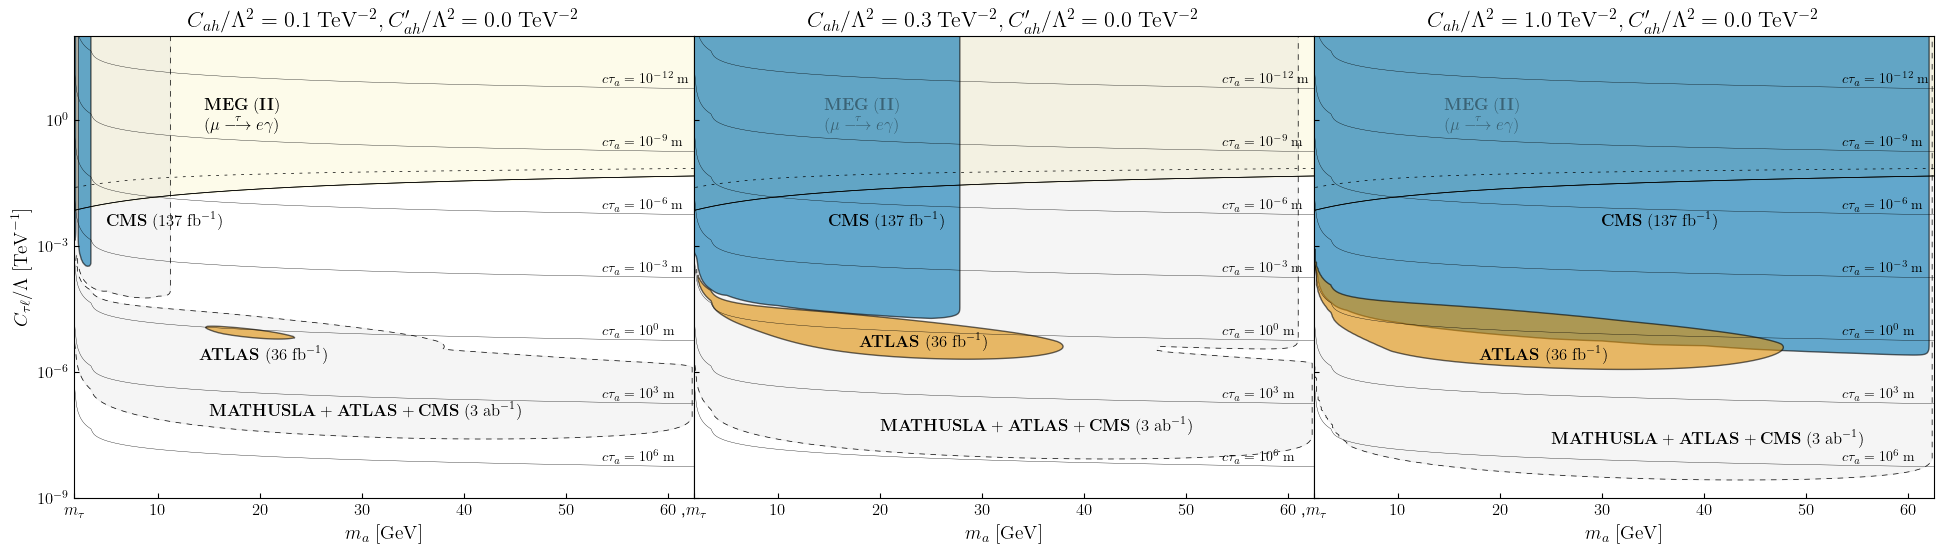

In [19]:
ma = np.linspace(0, 62.5, 400)

axes = plot_combined_limits(ma, [0.1, 0.3, 1.0])
axes[0].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[0].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[0].text(5, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(14, 2e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(15, 9e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[1].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[1].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[1].text(15, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(18, 4e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(20, 4e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[2].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[2].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[2].text(30, 3e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(18, 2e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(25, 2e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

plt.savefig('figures/chapter5/Ctl_vs_ma_limits_Cahp=0.pdf', format = 'pdf')

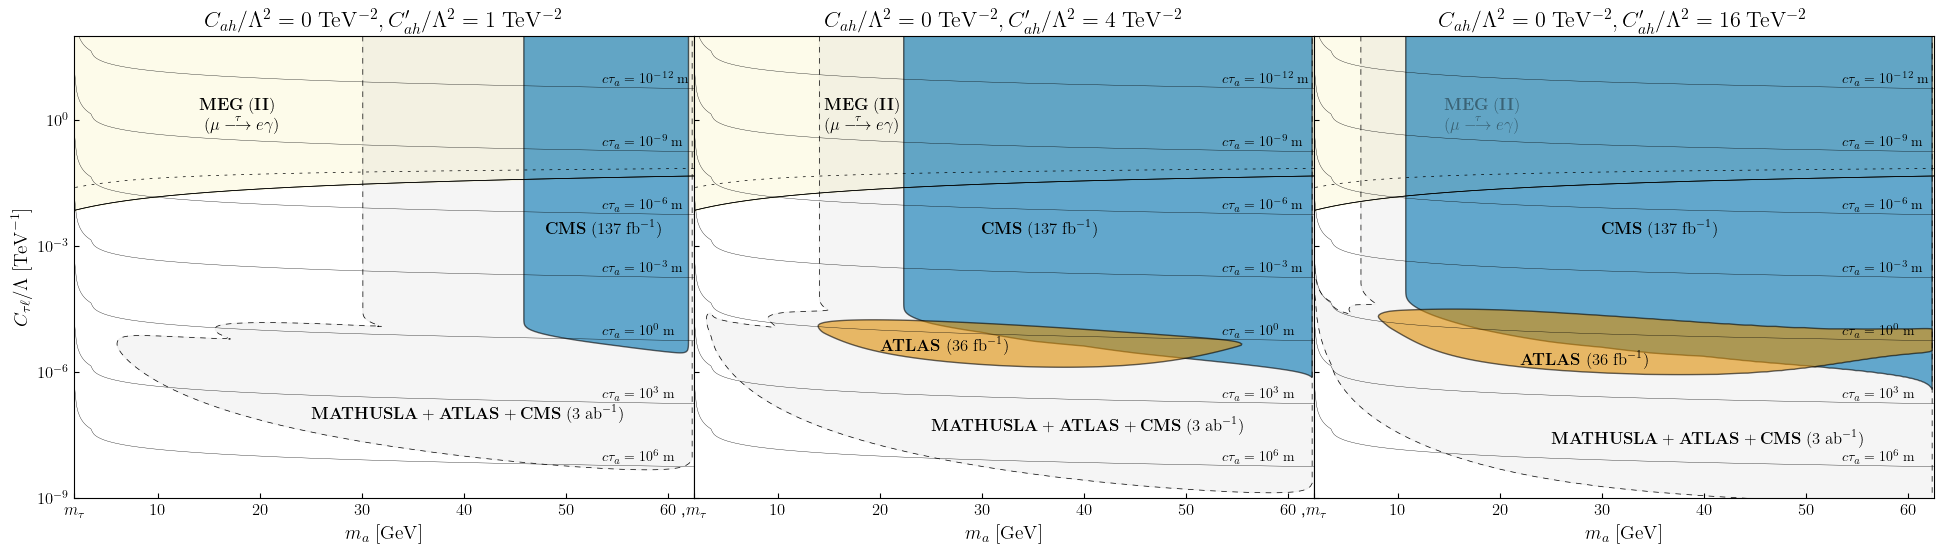

In [20]:
axes = plot_combined_limits(ma, [1, 4, 16], which = 'Cahp')

axes[0].text(14, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[0].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[0].text(48, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[0].text(25, 8e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[1].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12)
axes[1].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12)
axes[1].text(30, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(20, 3.2e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[1].text(25, 4e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

axes[2].text(14.5, 1.8, '${\\bf MEG~(II)}$', fontsize = 12, alpha = 0.4)
axes[2].text(14.6, 6e-1, '$(\\mu \\stackrel{\\tau}{\\longrightarrow} e\\gamma)$', fontsize = 12, alpha = 0.4)
axes[2].text(30, 2e-3, '${\\bf CMS}~(137~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(22, 1.5e-6, '${\\bf ATLAS}~(36~{\\rm fb}^{-1})$', fontsize = 12)
axes[2].text(25, 2e-8, '${\\bf MATHUSLA+ATLAS+CMS}~(3~{\\rm ab}^{-1})$', fontsize = 12)

plt.savefig('figures/chapter5/Ctl_vs_ma_limits_Cah=0.pdf', format = 'pdf')

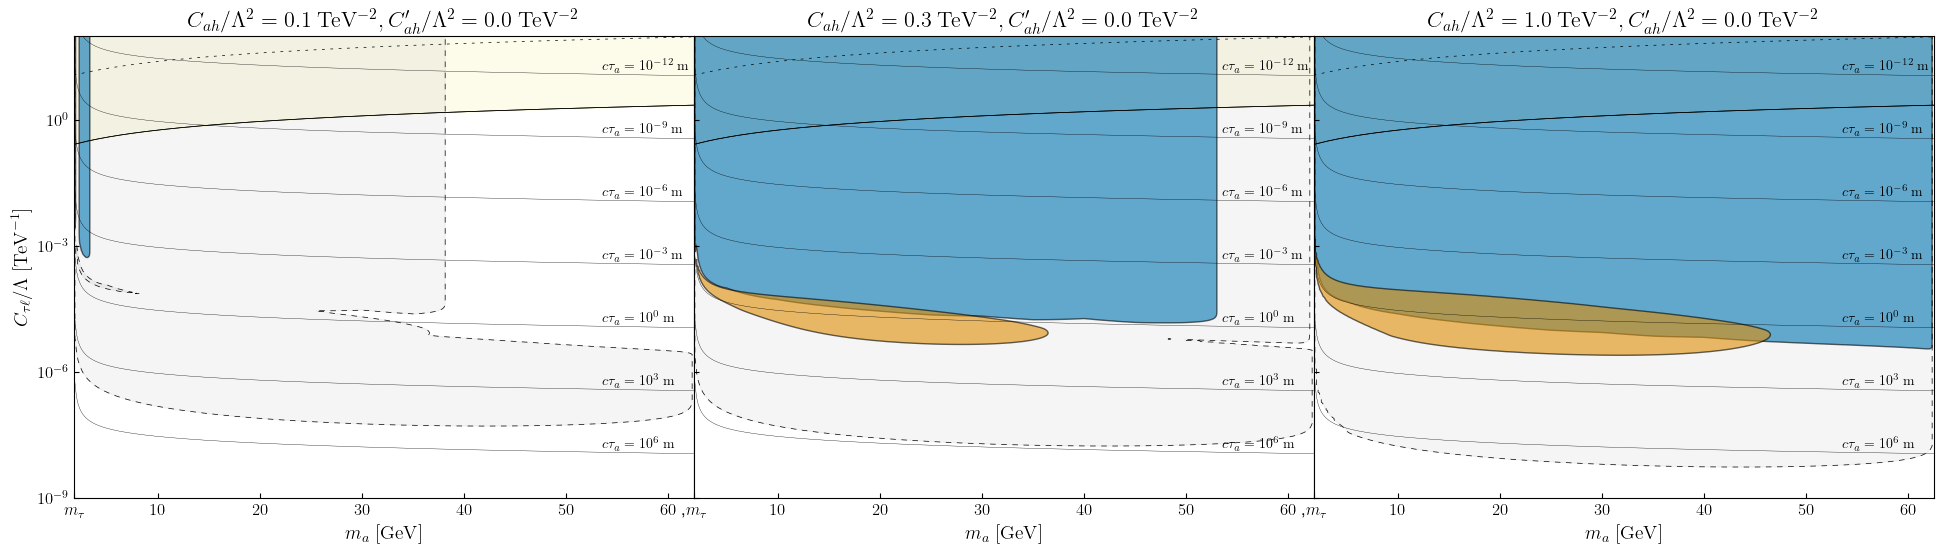

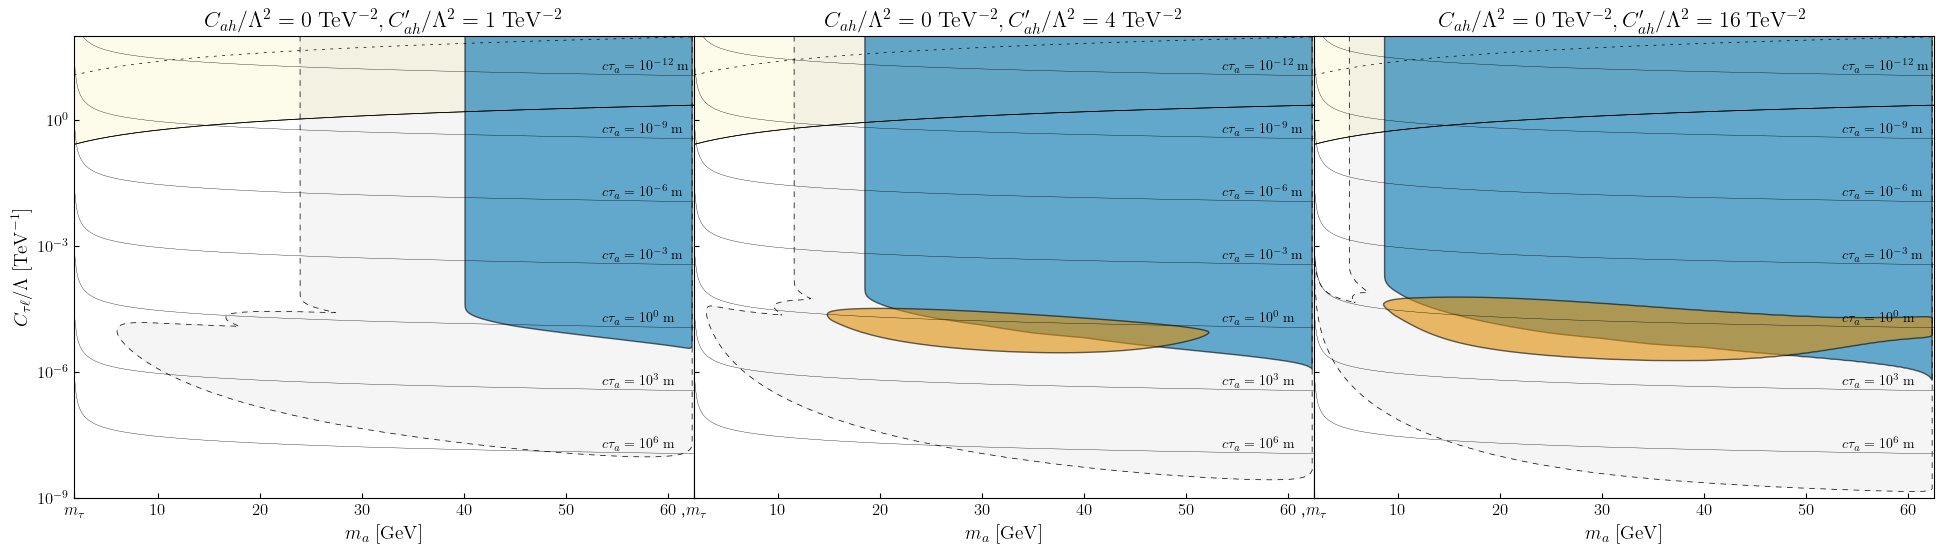

In [28]:
Cll = [[0, 0, 1],
       [0, 0, 0],
       [1, 0, 0]]

axes = plot_combined_limits(ma, [0.1, 0.3, 1.0], which = 'Cah', ij = (0, 2), Cll = Cll)
plt.show()
axes = plot_combined_limits(ma, [1, 4, 16], which = 'Cahp', ij = (0, 2), Cll = Cll)
plt.show()